In [1]:
# Импорт библиотек
import os
import time
import KU_TU
import GTU
import mat_properties as prop
import numpy as n
import pandas as pd
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel(
    "streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)

# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)

# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

############################################################
# Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at['GTU-KU', 'H'] = gas0.p_t(
    gas_streams.at['GTU-KU', 'P'], gas_streams.at['GTU-KU', 'T'])['h']
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0)

# Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.at["GTU-PEVD",
               "N2":"Ar"] = Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

############################################################
#Теплосеть
def Tset(Tnv):
    if Tnv <=-23.459064:
        Tpr=120
    if Tnv>-23.459064 and Tnv<=6.190058:
        Tpr=-1.01183432*Tnv+96.26331361
    if Tnv>6.190058:
        Tpr=90
    if Tnv <=-27.1:
        Tobr=70
    if Tnv>-27.1 and Tnv<=6.190058:
        Tobr=-1*Tnv+42.9
    if Tnv>6.190058:
        Tobr=0.1067856*Tnv+36.04893297
    return Tpr, Tobr
gas_streams.at["AIR", "T":"P"] = [GTU_input.loc["tair",1],0.1]
water_streams.at["AIR", "T":"P"] = [GTU_input.loc["tair",1],0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWIN-TURB", "T"] = Tset(Tnv)[0]
water_streams.at["SP2-WOUT", "T"] = Tset(Tnv)[1]
############################################################

# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)

# Основные константы
Calcmethod = "hybr"
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.9

Calctolerance = 10**-2
Teplo = 1
Maxiterations_KU_TU = 20
Maxiterations_cotel = 5
Maxiterations_turbine = 30

#Claas KU+TU
KU_and_TU=KU_TU.ku_tu(gas0, gas1,  water, gas_streams0, gas_streams, water_streams0, water_streams, heaters, electric,Calcmethod, KPD_SP, KPD_KN, KPD_to, KPD_PN)

start_time = time.time()

KU_and_TU.calculate(Teplo,Calctolerance,Maxiterations_KU_TU,Maxiterations_cotel,Maxiterations_turbine)

print("Степень сухости пара в ЭВД: ", water.p_h(
    water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],)
print("Степень сухости пара в ГПК: ", water.p_h(
    water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")

Достигнуто максимальное количество итераций контура высокого давления
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.7523673928881642
dQ/Q ПЕВД+ИВД+ЭВД -1.5721638781802216
dQ/Q ПЕВД+ИВД+ЭВД 0.7665175256067586
dQ/Q ПЕВД+ИВД+ЭВД -0.37392869287746267
dQ/Q ПЕВД+ИВД+ЭВД 0.1781430512284986
Достигнуто максимальное количество итераций контура высокого давления
dQ/Q ППНД+ИНД+ГПК 0.26223901208969824
dQ/Q ППНД+ИНД+ГПК -0.04444313616448101
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД -0.07944541049690873
dQ/Q ППНД+ИНД+ГПК -0.07094605014674189
Fin котел-утилизатора:--- 18.53 сек. ---
dQ/Qsumm -0.07533386848546927
Fin турбоустановка:--- 0.03 сек. ---
Достигнуто максимальное количество итераций контура высокого давления
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто макси

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 2.03 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    496.279454  8.232777  3387.426477   62.686553       NaN   
IVD-PEVD       299.864208  8.571488  2749.899509   62.686553       NaN   
EVD-IVD        291.288165  8.571488  1296.138352   62.686553       NaN   
PEN-EVD        166.487420  8.571488   708.165464   62.686553       NaN   
BND-PEN        164.863432  0.698565   696.640894   62.686553       NaN   
PPND-DROSND    207.983922  0.692466  2863.432499   15.438511       NaN   
IND-PPND       164.863431  0.698565  2762.666131   15.438511       NaN   
GPK-IND        164.863432  0.698565   721.651450   78.125064       NaN   
GPK-REC        164.863432  0.698565   721.651450 

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 1.77 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    496.191663  8.232777  3387.207515   62.776802       NaN   
IVD-PEVD       299.870972  8.572305  2749.886542   62.776802       NaN   
EVD-IVD        291.885825  8.572305  1299.420847   62.776802       NaN   
PEN-EVD        168.244822  8.572305   715.774723   62.776802       NaN   
BND-PEN        166.678111  0.730577   704.559172   62.776802       NaN   
PPND-DROSND    184.257774  0.692466  2809.821729   40.032156       NaN   
IND-PPND       166.678110  0.730577  2764.549586   40.032156       NaN   
GPK-IND        166.678111  0.730577  1219.165775  102.808959       NaN   
GPK-REC        166.678111  0.730577  1219.165775 

C:\Users\Admin\Documents\GitHub\GZ\cotel.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  G_rec = G_all*(h_gpk_in_60-h_gpk_in_rec) / \
C:\Users\Admin\Documents\GitHub\GZ\cotel.py:64: RuntimeWarning: invalid value encountered in double_scalars
  P22new = P21 - ((self.P021-self.P022)/ddp)


Достигнуто максимальное количество итераций контура ГПК


C:\Users\Admin\Documents\GitHub\GZ\cotel.py:568: RuntimeWarning: invalid value encountered in double_scalars
  Qw_gpk2 = self.water_streams.at['GPK-REC', 'G']*(


Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура низкого давления


C:\Users\Admin\Documents\GitHub\GZ\cotel.py:613: RuntimeWarning: invalid value encountered in double_scalars
  Qwat2ND = self.water_streams.at['GPK-REC', 'G']*(self.water_streams.at['GPK-REC', 'H']-self.water_streams.at['REC-GPK', 'H']) +\


Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура ГПК
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.72799167734558
dQ/Q ПЕВД+ИВД+ЭВД -1.554444466386472
dQ/Q ПЕВД+ИВД+ЭВД 0.762952569666161
dQ/Q ПЕВД+ИВД+ЭВД -0.38418454883053427
dQ/Q ПЕВД+ИВД+ЭВД 0.19023624255185786
Достигнуто максимальное количество итераций контура высокого давления
Достигнуто максимальное количество итераций контура ГПК
dQ/Q ППНД+ИНД+ГПК -298.60021463618045
Достигнуто максимальное количество итераций контура ГПК
dQ/Q ППНД+ИНД+ГПК -298.3272386904863
Достигнуто максимальное количество итераций контура ГПК
dQ/Q ППНД+ИНД+ГПК -298.35379206395845
Достигнуто максимальное количество итераций контура ГПК
d

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 1.9 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    511.779629  8.232777  3425.901476   62.567301       NaN   
IVD-PEVD       299.847383  8.569455  2749.931757   62.567301       NaN   
EVD-IVD        297.681573  8.569455  1331.788972   62.567301       NaN   
PEN-EVD        166.224663  8.569455   707.027495   62.567301       NaN   
BND-PEN        164.512304  0.692501   695.110052   62.567301       NaN   
PPND-DROSND    655.219321  0.692466  3824.354414    1.186162       NaN   
IND-PPND       164.512304  0.692501  2762.297498    1.186162       NaN   
GPK-IND         60.000000  0.692501   251.745122   63.753463       NaN   
GPK-REC         60.000000  0.692501   251.745122  

C:\Users\Admin\Documents\GitHub\GZ\cotel.py:64: RuntimeWarning: invalid value encountered in double_scalars
  P22new = P21 - ((self.P021-self.P022)/ddp)
C:\Users\Admin\Documents\GitHub\GZ\cotel.py:568: RuntimeWarning: invalid value encountered in double_scalars
  Qw_gpk2 = self.water_streams.at['GPK-REC', 'G']*(


Достигнуто максимальное количество итераций контура низкого давления
Fin котел-утилизатора:--- 5.92 сек. ---
dQ/Qsumm 0.06863512409123186


C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 1.81 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    496.137293  8.232777  3387.071901   62.653892       NaN   
IVD-PEVD       299.872940  8.572543  2749.882767   62.653892       NaN   
EVD-IVD        291.585068  8.572543  1297.767271   62.653892       NaN   
PEN-EVD        166.803508  8.572543   709.533890   62.653892       NaN   
BND-PEN        165.153465  0.703605   697.905691   62.653892       NaN   
PPND-DROSND    198.726161  0.692466  2842.805084   21.379960       NaN   
IND-PPND       165.153465  0.703605  2762.969601   21.379960       NaN   
GPK-IND        165.153465  0.703605   867.106676   84.033853       NaN   
GPK-REC        165.153465  0.703605   867.106676 

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 1.73 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    495.795906  8.232777  3386.220282   62.907828       NaN   
IVD-PEVD       299.884195  8.573903  2749.861183   62.907828       NaN   
EVD-IVD        292.438513  8.573903  1302.464085   62.907828       NaN   
PEN-EVD        171.288849  8.573903   728.978006   62.907828       NaN   
BND-PEN        169.799166  0.788349   718.204460   62.907828       NaN   
PPND-DROSND    178.171927  0.692466  2795.579472   63.840104       NaN   
IND-PPND       169.799166  0.788349  2767.702657   63.840104       NaN   
GPK-IND        169.799166  0.788349  1522.473463  126.747932       NaN   
GPK-REC        169.799166  0.788349  1522.473463 

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 1.86 сек. ---
Переход к оригинально точности расчета 0.01
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    496.651569  8.252891  3388.108746   62.415455       NaN   
IVD-PEVD       300.013349  8.589520  2749.613083   62.415455       NaN   
EVD-IVD        290.476070  8.589520  1291.677390   62.415455       NaN   
PEN-EVD        215.597475  8.589520   925.330153   62.415455       NaN   
BND-PEN        213.652640  2.050941   914.342286   62.415455       NaN   
PPND-DROSND    380.395383  2.050831  3204.202150    3.522698       NaN   
IND-PPND       213.652640  2.050941  2798.803839    3.522698       NaN   
GPK-IND        169.603689  2.050941   718.042727   65.938153       NaN   
GPK-R

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 2.02 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    510.963680  8.252891  3423.653429   63.018065       NaN   
IVD-PEVD       300.057609  8.594877  2749.527885   63.018065       NaN   
EVD-IVD        300.057609  8.594877  1348.087684   63.018065       NaN   
PEN-EVD        215.306730  8.594877   924.012141   63.018065       NaN   
BND-PEN        213.682707  2.052154   914.480180   63.018065       NaN   
PPND-DROSND    241.829683  2.050831  2879.674115   12.249765       NaN   
IND-PPND       213.682707  2.052154  2798.815571   12.249765       NaN   
GPK-IND        213.682707  2.052154   961.744411   75.267830       NaN   
GPK-REC        213.682707  2.052154   961.744411 

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 1.88 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    510.985568  8.252891  3423.707562   63.018559       NaN   
IVD-PEVD       300.056122  8.594697  2749.530747   63.018559       NaN   
EVD-IVD        300.056122  8.594697  1347.861045   63.018559       NaN   
PEN-EVD        215.317299  8.594697   924.060050   63.018559       NaN   
BND-PEN        213.693313  2.052582   914.528826   63.018559       NaN   
PPND-DROSND    238.459947  2.050831  2870.666313   14.127980       NaN   
IND-PPND       213.693314  2.052582  2798.819707   14.127980       NaN   
GPK-IND        213.693313  2.052582  1006.656120   77.146539       NaN   
GPK-REC        213.693313  2.052582  1006.656120 

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 1.89 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    510.982931  8.252891  3423.701041   63.019517       NaN   
IVD-PEVD       300.056298  8.594718  2749.530409   63.019517       NaN   
EVD-IVD        300.056298  8.594718  1347.883157   63.019517       NaN   
PEN-EVD        215.336729  8.594718   924.148239   63.019517       NaN   
BND-PEN        213.712725  2.053365   914.617854   63.019517       NaN   
PPND-DROSND    235.980596  2.050831  2863.956499   16.998696       NaN   
IND-PPND       213.712725  2.053365  2798.827270   16.998696       NaN   
GPK-IND        213.712725  2.053365  1072.032983   80.018213       NaN   
GPK-REC        213.712725  2.053365  1072.032983 

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 1.93 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    510.991527  8.252891  3423.722301   63.017435       NaN   
IVD-PEVD       300.056155  8.594701  2749.530684   63.017435       NaN   
EVD-IVD        300.056155  8.594701  1348.004274   63.017435       NaN   
PEN-EVD        215.393417  8.594701   924.405532   63.017435       NaN   
BND-PEN        213.769381  2.055653   914.877716   63.017435       NaN   
PPND-DROSND    231.866831  2.050831  2852.651942   23.457679       NaN   
IND-PPND       213.769381  2.055653  2798.849310   23.457679       NaN   
GPK-IND        213.769381  2.055653  1202.829154   86.475114       NaN   
GPK-REC        213.769381  2.055653  1202.829154 

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 1.85 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    511.124612  8.311934  3423.372815   62.798063       NaN   
IVD-PEVD       300.503627  8.649004  2748.664258   62.798063       NaN   
EVD-IVD        299.851094  8.649004  1344.077441   62.798063       NaN   
PEN-EVD        200.542406  8.649004   857.632929   62.798063       NaN   
BND-PEN        198.849688  1.517866   847.088059   62.798063       NaN   
PPND-DROSND    204.608809  1.438778  2813.092816   81.958874       NaN   
IND-PPND       198.849689  1.517866  2791.305785   81.958874       NaN   
GPK-IND        198.849688  1.517866  1792.671699  144.756938       NaN   
GPK-REC        198.849688  1.517866  1792.671699 

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 1.97 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    511.181511  8.311934  3423.513686   62.769191       NaN   
IVD-PEVD       300.499573  8.648511  2748.672150   62.769191       NaN   
EVD-IVD        299.684367  8.648511  1343.121176   62.769191       NaN   
PEN-EVD        198.052429  8.648511   846.545093   62.769191       NaN   
BND-PEN        196.347050  1.439614   835.834632   62.769191       NaN   
PPND-DROSND    242.047635  1.438778  2907.525660    8.204552       NaN   
IND-PPND       196.347050  1.439614  2789.714336    8.204552       NaN   
GPK-IND        171.723117  1.439614   726.964126   70.973743       NaN   
GPK-REC        171.723117  1.439614   726.964126 

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 2.02 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    511.152542  8.311934  3423.441964   62.774117       NaN   
IVD-PEVD       300.501791  8.648781  2748.667833   62.774117       NaN   
EVD-IVD        299.731663  8.648781  1343.392184   62.774117       NaN   
PEN-EVD        198.117138  8.648781   846.832980   62.774117       NaN   
BND-PEN        196.414822  1.441691   836.138965   62.774117       NaN   
PPND-DROSND    228.225860  1.438778  2874.018636   15.348867       NaN   
IND-PPND       196.414822  1.441691  2789.758610   15.348867       NaN   
GPK-IND        196.414822  1.441691   919.807593   78.122984       NaN   
GPK-REC        196.414822  1.441691   919.807593 

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Недостаточное количество итераций
Fin турбоустановка:--- 2.15 сек. ---
                        T         P            H           G         S  \
AIR             15.000000  0.100000          NaN         NaN       NaN   
PEVD-DROSVD    511.166121  8.311934  3423.475583   62.785832       NaN   
IVD-PEVD       300.500895  8.648672  2748.669576   62.785832       NaN   
EVD-IVD        299.752516  8.648672  1343.511977   62.785832       NaN   
PEN-EVD        198.347446  8.648672   847.857310   62.785832       NaN   
BND-PEN        196.652363  1.448988   837.205825   62.785832       NaN   
PPND-DROSND    216.258368  1.438778  2843.896924   28.798092       NaN   
IND-PPND       196.652364  1.448988  2789.913275   28.798092       NaN   
GPK-IND        196.652363  1.448988  1198.441109   91.583924       NaN   
GPK-REC        196.652363  1.448988  1198.441109 

C:\Users\Admin\Documents\GitHub\GZ\SP.py:35: RuntimeWarning: invalid value encountered in sqrt
  epsilon=min(0.999, 1/(0.35*min(Gdr,God)/max(Gdr,God)+0.65+1/self.F*n.sqrt(min(Gdr,God)/max(Gdr,God))))


Достигнуто максимальное количество итераций давления верхнего отбора
Не возможно получить необходимое давление, диафрагма полностью открыта
Расход в конденсатор равен нулю
Fin турбоустановка:--- 1.57 сек. ---
                        T           P            H            G         S  \
AIR             15.000000    0.100000          NaN          NaN       NaN   
PEVD-DROSVD    511.121187    8.311934  3423.364335    62.816218       NaN   
IVD-PEVD       300.503501    8.648989  2748.664504    62.816218       NaN   
EVD-IVD        299.931942    8.648989  1344.541808    62.816218       NaN   
PEN-EVD        202.532270    8.648989   866.515122    62.816218       NaN   
BND-PEN        200.846707    1.582656   856.090898    62.816218       NaN   
PPND-DROSND    196.758883    1.438778  2790.981891 -1149.864189       NaN   
IND-PPND       200.846707    1.582656  2792.510858 -1149.864189       NaN   
GPK-IND        251.707589    1.582656  2924.686025 -1087.047971       NaN   
GPK-REC        251.70

Error in sys.excepthook:
Traceback (most recent call last):
  File "c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 1958, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 1960, in showtraceback
    stb = self.InteractiveTB.structured_traceback(etype,
  File "c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\IPython\core\ultratb.py", line 1105, in structured_traceback
    return FormattedTB.structured_traceback(
  File "c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\IPython\core\ultratb.py", line 999, in structured_traceback
    return VerboseTB.structured_traceback(
  File "c:\us

Достигнуто максимальное количество итераций контура высокого давления


error: Result from function call is not a proper array of floats.

In [2]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,15.000000,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,309.510993,0.1,697.756698,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,312.049531,0.1,700.527790,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,-67.116058,0.1,195.098012,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,-66.444891,0.1,195.866584,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,62.544618,0.1,434.666565,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,35.438216,0.1,391.130156,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065


In [3]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,1.500000e+01,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,-1.000026e+07,9.473975,6.048540e+07,0.000012,NaN,NaN
IVD-PEVD,3.070495e+02,9.473975,2.734882e+03,0.000012,NaN,NaN
EVD-IVD,-1.000026e+07,9.473975,2.088705e+10,0.000012,NaN,NaN
PEN-EVD,-6.809591e+01,9.473975,-3.185267e+06,0.000012,NaN,NaN
BND-PEN,-1.000026e+07,298.653956,-9.999990e+03,0.000012,NaN,NaN
PPND-DROSND,2.685000e+01,298.653956,-9.994795e+03,-73.747575,NaN,NaN
IND-PPND,2.685000e+01,298.653956,-9.999990e+03,-73.747575,NaN,NaN
GPK-IND,2.685000e+01,298.653956,-1.647787e+03,-11.317939,NaN,NaN
GPK-REC,2.685000e+01,298.653956,-1.647787e+03,-10.719319,NaN,NaN


In [4]:
Errors_water = abs(water_streams - water_streams0)/water_streams0*100
Errors_gas = abs(gas_streams-gas_streams0)/gas_streams0*100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,99.999981,1.536583e+03,42785.404332,NaN,6.070491e+06,NaN
DOOTB1,99.998721,2.818291e+01,97.770492,10.256391,NaN,NaN
DOOTB2,1490.798325,3.010326e+01,98.662470,9.707325,8.007564e+01,NaN
DROSND-TURBND,7890.407787,2.801571e+00,62538.913548,35.373408,2.065270e+02,NaN
DROSVD-TURBVD,0.920791,2.451005e-02,28.462827,NaN,2.077807e+00,NaN
ENDOFVD,0.920791,1.604519e+01,1073.579264,NaN,1.306302e+02,NaN
EVD-IVD,99.999981,1.561125e+09,8.323517,NaN,3.346908e+06,NaN
GPK-BYPASS,NaN,NaN,NaN,NaN,NaN,NaN
GPK-IND,114.480474,3.369233e+02,42785.404332,NaN,8.368773e+01,NaN


In [5]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
water_streams0

,T,P,H,G,S
PEVD-DROSVD,511.500000,8.407000,3423.209978,63.400000,NaN
IVD-PEVD,301.297556,8.746000,2747.104023,63.400000,NaN
EVD-IVD,298.800000,8.746000,1337.948265,63.400000,NaN
PEN-EVD,166.500000,8.746000,708.319849,63.400000,NaN
BND-PEN,164.738361,0.696400,696.095567,63.400000,NaN
PPND-DROSND,211.600000,0.691000,2871.481837,14.760000,NaN
IND-PPND,164.738361,0.696400,2762.534980,14.760000,NaN
GPK-IND,164.600000,0.696400,695.493701,78.160000,NaN
GPK-REC,164.600000,0.696400,695.493701,82.910000,NaN
REC-GPK,60.000000,0.696400,251.748396,82.910000,NaN


In [7]:
electric

,Ni,N,KPDm,KPD
PEN,-1.982308e+05,-1.982308e+06,0.100000,0.702741
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,1.507506e+02,NaN,33.348086
DK,NaN,6.269747e+00,NaN,NaN
Turbine,-9.238274e+02,NaN,NaN,NaN
Tots1,7.708073e+00,NaN,NaN,NaN
Tots2,-9.315354e+02,NaN,NaN,NaN
Tots3,7.193707e-12,NaN,NaN,NaN
Tots4,1.353557e-11,NaN,NaN,NaN


In [8]:
heaters

,Qw,Qg,KPD
PEVD,129987.673654,131300.680459,0.99
IVD,-1381.285403,-1395.237781,0.99
EVD,251937.747074,254482.572802,0.99
PPND,-383.104202,-386.973942,0.99
IND,94529.725895,95484.571611,0.99
GPK,21701.263663,21920.468347,0.99
SP2,-208.428806,NaN,0.90
SP1,0.000000,NaN,0.90
OD,31.051690,NaN,0.90


In [9]:
GTU_input

,1,2,3,4,5,6
tair,15,NaN,NaN,NaN,NaN,NaN
n,1,NaN,NaN,NaN,NaN,NaN
Pin,0,NaN,NaN,NaN,NaN,NaN
Pout,0,NaN,NaN,NaN,NaN,NaN


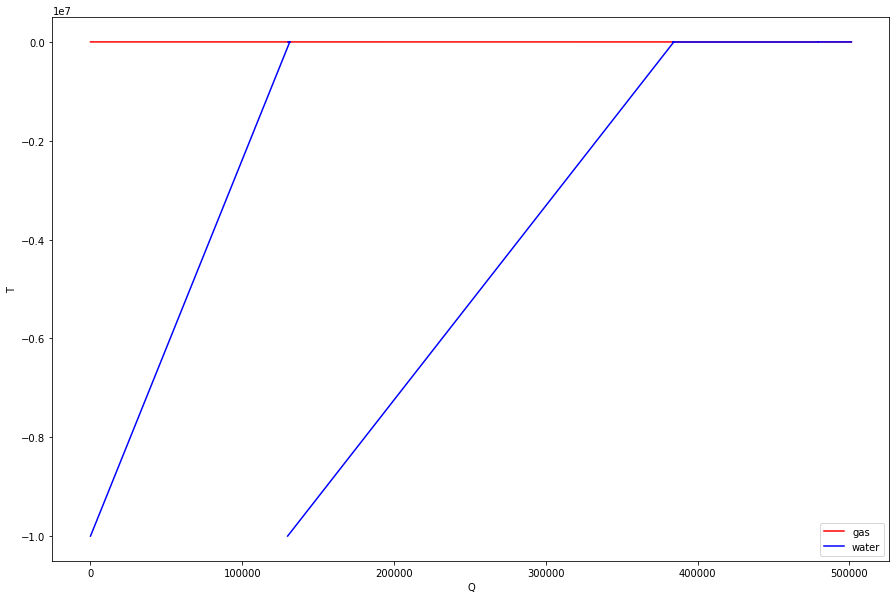

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
Qg = [0,
      heaters.loc['PEVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg']+heaters.loc['PPND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD', 'Qg'] +
      heaters.loc['PPND', 'Qg'] +
      heaters.loc['IND', 'Qg']+heaters.loc['GPK', 'Qg']
      ]
Qw = [0,
      heaters.loc['PEVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg']+heaters.loc['PPND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD', 'Qg'] +
      heaters.loc['PPND', 'Qg'] +
      heaters.loc['IND', 'Qg']+heaters.loc['GPK', 'Qg']
      ]
Tg = gas_streams.loc['GTU-PEVD':'GPK-out', 'T']
Tw = [water_streams.loc['PEVD-DROSVD', 'T'],
      water_streams.loc['IVD-PEVD', 'T'],
      water_streams.loc['IVD-PEVD', 'T'],
      water_streams.loc['EVD-IVD', 'T'],
      water_streams.loc['PEN-EVD', 'T'],
      water_streams.loc['PPND-DROSND', 'T'],
      water_streams.loc['IND-PPND', 'T'],
      water_streams.loc['IND-PPND', 'T'],
      water_streams.loc['GPK-REC', 'T'],
      water_streams.loc['REC-GPK', 'T'],
      ]
plt.plot(Qg, Tg, color='red')
plt.plot(Qw[0:2], Tw[0:2], color='blue')
plt.plot(Qw[1:3], Tw[1:3], color='blue')
plt.plot(Qw[3:5], Tw[3:5], color='blue')
plt.plot(Qw[5:7], Tw[5:7], color='blue')
plt.plot(Qw[6:8], Tw[6:8], color='blue')
plt.plot(Qw[8:10], Tw[8:10], color='blue')
plt.xlabel('Q')
plt.ylabel('T')
plt.legend(['gas', 'water'])
plt.show()

In [11]:
# # Импорт библиотек
# import os
# import time
# import cotel
# import Turboustanovka
# import GTU
# import mat_properties as prop
# import numpy as n
# import pandas as pd
# from scipy.optimize import root

# # таблица номинального режима
# gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
# water_streams0 = pd.read_excel(
#     "streams0.xlsx", sheet_name="water", index_col=0)
# GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
# GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# # рабочая таблица (=номинал в 1 итерации)
# gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
# water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# # рабочая таблица показателей блоков
# heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
# electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)

# # Состав газов в номинале
# gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# # Считывание рефпропа
# RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
# fractiongas0 = (
#     gas_streams0.at["GTU-PEVD", "N2"],
#     gas_streams0.at["GTU-PEVD", "O2"],
#     gas_streams0.at["GTU-PEVD", "CO2"],
#     gas_streams0.at["GTU-PEVD", "H2O"],
#     gas_streams0.at["GTU-PEVD", "Ar"],
# )

# gas0 = prop.Materials_prop(
#     gasmix,
#     fractiongas0,
#     prop.REFPROP_h_s,
#     prop.REFPROP_p_t,
#     prop.REFPROP_p_h,
#     prop.REFPROP_p_s,
#     prop.REFPROP_p_q,
#     prop.REFPROP_t_q,
#     prop.REFPROP_p_rho,
#     RP=RP,
# )
# water = prop.Materials_prop(
#     "water",
#     [1.0, 0, 0, 0, 0],
#     prop.REFPROP_h_s,
#     prop.REFPROP_p_t,
#     prop.REFPROP_p_h,
#     prop.REFPROP_p_s,
#     prop.REFPROP_p_q,
#     prop.REFPROP_t_q,
#     prop.REFPROP_p_rho,
#     RP=RP,
# )


# # Задание энтальпий газа в номинальном режиме
# Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
# Pressure = gas_streams0.loc["GTU-KU", "P"]
# Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
# gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies


# ####################################################################################################
# # Расчет ГТУ
# Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
# Gas_turbine_res = Gas_turbine.calc()
# electric.at["GTU", "N"] = Gas_turbine_res["N"]
# electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
# electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
# gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
# gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
# gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
# gas_streams.at["GTU-KU", "P"] = 0.1
# gas_streams.at['GTU-KU', 'H'] = gas0.p_t(
#     gas_streams.at['GTU-KU', 'P'], gas_streams.at['GTU-KU', 'T'])['h']
# Gas_turbine_composition = pd.read_excel(
#     "input.xlsx", sheet_name="Gas_composition0", index_col=0)

# # Параметры газа на выходе в КУ
# gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
# gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
# gas_streams.at["GTU-PEVD",
#                "N2":"Ar"] = Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

# # Состав газов при частичной нагрузке
# fractiongas = (
#     gas_streams.at["GTU-PEVD", "N2"],
#     gas_streams.at["GTU-PEVD", "O2"],
#     gas_streams.at["GTU-PEVD", "CO2"],
#     gas_streams.at["GTU-PEVD", "H2O"],
#     gas_streams.at["GTU-PEVD", "Ar"],
# )
# gas1 = prop.Materials_prop(
#     gasmix,
#     fractiongas,
#     prop.REFPROP_h_s,
#     prop.REFPROP_p_t,
#     prop.REFPROP_p_h,
#     prop.REFPROP_p_s,
#     prop.REFPROP_p_q,
#     prop.REFPROP_t_q,
#     prop.REFPROP_p_rho,
#     RP=RP,
# )

# # Основные константы
# Calcmethod = "hybr"
# KPDnasos = 0.8074
# KPD = 0.99
# Calctolerance = 10**-2
# Teplo = 1
# Maxiterations_cotel = 10
# Maxiterations_KU_TU = 20
# Maxiterations_turbine = 30

# ####################################################################################################
# # Инициализируем все
# TU = Turboustanovka.turboustanovka(
#     water, water_streams0, water_streams, heaters, electric, KPD_SP=0.99, KPDnasos=0.8)
# Whole_cotel = cotel.cotel_all(KPD, KPDnasos,  gas0, gas1, water, Calcmethod,
#                               gas_streams0, water_streams0, gas_streams, water_streams, heaters, electric)


# Vvd0 = 1/water.p_h(water_streams0.at["PEVD-DROSVD", 'P'],
#                    water_streams0.at["PEVD-DROSVD", 'H'])['rho']
# Vnd0 = 1/water.p_h(water_streams0.at["PPND-DROSND", 'P'],
#                    water_streams0.at["PPND-DROSND", 'H'])['rho']
# Gvd0 = water_streams0.at["PEVD-DROSVD", 'G']
# Gnd0 = water_streams0.at["PPND-DROSND", 'G']
# dPvd0 = water_streams0.at["PEVD-DROSVD", 'P'] - \
#     water_streams0.at["DROSVD-TURBVD", 'P']
# dPnd0 = water_streams0.at["PPND-DROSND", 'P'] - \
#     water_streams0.at["DROSND-TURBND", 'P']

# ####################################################################################################
# # Расчет всего
# Pnd_it = []
# Pvd_it = []
# start_time = time.time()
# Max_error_P = 2
# Max_error_G = 2
# Max_error = 2
# Error_nd_P = 2
# Error_vd_P = 2
# Calctolerance_new = 10**-1
# Teplo_overflow = 0

# #Первое приближение по давлению
# G_gas1 = gas_streams.at["GTU-PEVD", "G"]
# G_gas0 = gas_streams0.at["GTU-PEVD", "G"]
# g_gas = G_gas1/G_gas0
# Pvd_1 = 0.4538+7.7601*g_gas
# Pnd_1 = -0.0189+0.6885*g_gas
# water_streams.at["PPND-DROSND", 'P'] = Pnd_1
# water_streams.at["PEVD-DROSVD", 'P'] = Pvd_1
# print('Pnd_1', Pnd_1)
# print('Pvd_1', Pvd_1)

# for i in range(Maxiterations_KU_TU):

#     for j in range(Maxiterations_cotel):

#         # Расчет котла
#         Whole_cotel.calc(Calctolerance_new, Maxiterations_cotel)
#         # print('КУ расчитан')

#         Gnd1 = water_streams.at["PPND-DROSND", "G"]
#         Gnd2 = water_streams.at["DROSND-TURBND", "G"]
#         Gvd1 = water_streams.at["PEVD-DROSVD", "G"]
#         Gvd2 = water_streams.at["DROSVD-TURBVD", "G"]

#         # Перекидываем расходы
#         water_streams.at["DROSVD-TURBVD", 'G'] = Gvd1
#         water_streams.at["DROSND-TURBND", 'G'] = Gnd1

#         # Перекидываем энтальпии
#         water_streams.at["DROSVD-TURBVD",
#                          'H'] = water_streams.at["PEVD-DROSVD", 'H']
#         water_streams.at["DROSND-TURBND",
#                          'H'] = water_streams.at["PPND-DROSND", 'H']
#         if i > 0 and Teplo == 1:
#             teplofikacia = 1
#         else:
#             teplofikacia = 0
#         # Расчет турбины
#         TU_res = TU.calculate(
#             teplofikacia, calcmethod="hybr", calctolerance=Calctolerance_new, maxiterations=Maxiterations_turbine
#         )
#         # print('ТУ рассчитана')

#         # основные потоки, которые надо сводить по расходу
#         # Calctolerance_new=Calctolerance
#         # if Max_error > 0.1 and Max_error <= 1:
#         #     print('Max_error', 0.01)
#         #     Calctolerance_new = Calctolerance*10
#         # if Max_error > 1:
#         #     print('Max_error', 1)
#         Calctolerance_new = Calctolerance*10
#         if  i>2:
#             print('Переход к оригинально точности расчета',Calctolerance)
#             Calctolerance_new = Calctolerance
#         # if Max_error_P < Calctolerance:
#         #     print('Max_error_10', 0.01)
#         #     Calctolerance_new = Calctolerance
#         # if Max_error < 0.01:
#         #     print('Max_error', 'else')
#         #     Calctolerance_new = Calctolerance

#         Error_water_G = abs((water_streams.at["SMESHOD-REC", "G"] -
#                              water_streams.at["GPK-IND", "G"])/water_streams.at["GPK-IND", "G"]*100)
#         Error_nd_G = abs((Gnd1 - Gnd2)/Gnd1*100)
#         Error_vd_G = abs((Gvd1 - Gvd2)/Gvd1*100)
#         Max_error_G = max(Error_water_G, Error_nd_G, Error_vd_G)
#         Max_error = max(Error_water_G, Error_nd_G,
#                         Error_vd_G, Error_nd_P, Error_vd_P)
#         print('Max_error_G', Max_error_G)
#         print('Error_nd_G', Error_nd_G)
#         print('Error_vd_G', Error_vd_G)
#         print('Error_water_G', Error_water_G)
#         if Error_water_G > 20:
#             Teplo_overflow = 1
#         if abs(Max_error_G) < Calctolerance_new:
#             print(
#                 "Максимальная погрешность определения расхода в КУ+ПТУ", Max_error_G)
#             break
#         if j == Maxiterations_cotel - 1:
#             print("Достигнуто максимальное количество итераций расхода КУ+ПТУ")

#     # Переписываю давления
#     P_turb_vd = water_streams.at["DROSVD-TURBVD", 'P']
#     P_turb_nd = water_streams.at["DROSND-TURBND", 'P']
#     Vvd1 = 1/water.p_h(water_streams0.at["PEVD-DROSVD", 'P'],
#                        water_streams0.at["PEVD-DROSVD", 'H'])['rho']
#     Vnd1 = 1/water.p_h(water_streams0.at["PPND-DROSND", 'P'],
#                        water_streams0.at["PPND-DROSND", 'H'])['rho']
#     dPvd = dPvd0 * (Gvd1*Vvd1/Gvd0/Vvd0)**2*Vvd0/Vvd1
#     dPnd = dPnd0*(Gnd1*Vnd1/Gnd0/Vnd0)**2*Vnd0/Vnd1
#     P_kotel_vd = water_streams.at["PEVD-DROSVD", 'P']
#     P_kotel_nd = water_streams.at["PPND-DROSND", 'P']
#     P_kotel_nd_new = P_turb_nd+dPnd
#     P_kotel_vd_new = P_turb_vd+dPvd
#     water_streams.at["PPND-DROSND", 'P'] = (P_kotel_nd_new+P_kotel_nd)/2
#     water_streams.at["PEVD-DROSVD", 'P'] = (P_kotel_vd_new+P_kotel_vd)/2

#     # Закидываю давления в массив
#     Pnd_it.append(round(water_streams.loc['PPND-DROSND', 'P'], 5))
#     Pvd_it.append(round(water_streams.loc['PEVD-DROSVD', 'P'], 5))
#     print('Pnd_it', Pnd_it)
#     print('Pvd_it', Pvd_it)

#     # Ошибки расчета
#     Error_nd_P = abs((P_kotel_nd - P_kotel_nd_new)/P_kotel_nd*100)
#     Error_vd_P = abs((P_kotel_vd - P_kotel_vd_new)/P_kotel_vd*100)
#     Max_error = max(Error_water_G, Error_nd_G,
#                     Error_vd_G, Error_nd_P, Error_vd_P)
#     print('Error_nd_P', Error_nd_P)
#     print('Error_vd_P', Error_vd_P)
#     Max_error_P = max(Error_nd_P, Error_vd_P)
#     print('Max_error', Max_error)
#     print(
#         f"Время {i+1} итерации расчета КУ+ТУ:--- %s сек. --- {round((time.time() - start_time), 1)}")
#     if Teplo_overflow == 1:
#         print('Слишком большая теплофикационная мощность, расчет окончен.')
#         print('Для правильного расчета необходимо повысить мощность ГТУ или уменьшить мощность теплофикации.')
#     if abs(Max_error) < Calctolerance and Calctolerance_new == Calctolerance:
#         print(
#             "Максимальная погрешность определения расходов", Error_water_G)
#         break
#     if i == Maxiterations_KU_TU - 1:
#         print("Достигнуто максимальное количество итераций давления КУ+ПТУ", i+1)

# print("Степень сухости пара в ЭВД: ", water.p_h(
#     water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],)
# print("Степень сухости пара в ГПК: ", water.p_h(
#     water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],)

# print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")

NameError: name 'Pvd_it' is not defined

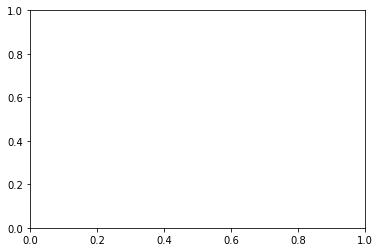

In [12]:
import matplotlib.pyplot as plt
import matplotlib

# plt.style.use('_mpl-gallery')
# plt.figure(figsize=(20,5))
# plot
i=10
fig, ax = plt.subplots()
x = range(0, i+1)
y = Pvd_it
plt.plot(x, y, linewidth=2.0)
fig.set_size_inches(20, 5)

# ax.set(xlim=(0, 8),
#        ylim=(0, 8))
# loc = matplotlib.ticker.LinearLocator(numticks = len(x)-1)
# plt.gca().xaxis.set_major_locator(loc)
ax.set_xticks(x)
plt.show()

                          T           P             H            G  \
AIR            1.500000e+01    0.100000           NaN          NaN   
PEVD-DROSVD   -1.000026e+07    9.473975  6.048540e+07     0.000012   
IVD-PEVD       3.070495e+02    9.473975  2.734882e+03     0.000012   
EVD-IVD       -1.000026e+07    9.473975  2.088705e+10     0.000012   
PEN-EVD       -6.809591e+01    9.473975 -3.185267e+06     0.000012   
BND-PEN       -1.000026e+07  298.653956 -9.999990e+03     0.000012   
PPND-DROSND    2.685000e+01  298.653956 -9.994795e+03   -73.747575   
IND-PPND       2.685000e+01  298.653956 -9.999990e+03   -73.747575   
GPK-IND        2.685000e+01  298.653956 -1.647787e+03   -11.317939   
GPK-REC        2.685000e+01  298.653956 -1.647787e+03   -10.719319   
REC-GPK        8.964387e+01  298.653956  3.767137e+02   -11.317939   
SMESHOD-REC    8.964387e+01  298.653956  3.767137e+02  -127.517328   
GPK-RECIRC              NaN         NaN           NaN          NaN   
GPK-BYPASS          

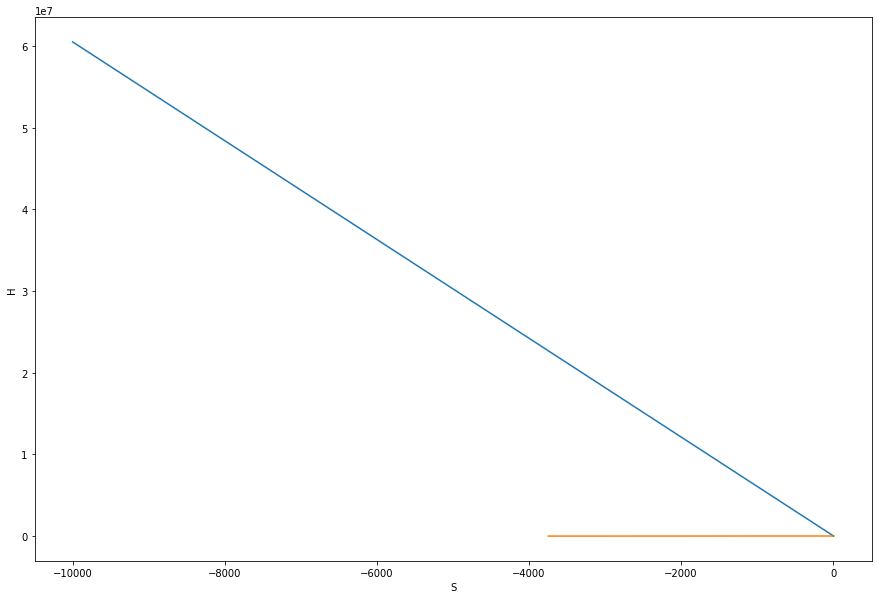

In [14]:
print(water_streams)
import matplotlib.pyplot as plt


water_streams.at['PEVD-DROSVD', 'S'] = water.p_h(water_streams.at['PEVD-DROSVD', 'P'],water_streams.at['PEVD-DROSVD', 'H'])['s']
water_streams.at['PPND-DROSND', 'S'] = water.p_h(water_streams.at['PPND-DROSND', 'P'],water_streams.at['PPND-DROSND', 'H'])['s']

plt.figure(figsize=(15,10))
Hvd = [water_streams.at['PEVD-DROSVD', 'H'],
       water_streams.at['DROSVD-TURBVD', 'H'],
       water_streams.at['ENDOFVD', 'H'],
]
Svd = [water_streams.at['PEVD-DROSVD', 'S'],
       water_streams.at['DROSVD-TURBVD', 'S'],
       water_streams.at['ENDOFVD', 'S'],
]
Hsm = [water_streams.at['PPND-DROSND', 'H'],
       water_streams.at['DROSND-TURBND', 'H'],
       water_streams.at['SMESHEND', 'H'],
]
Ssm = [water_streams.at['PPND-DROSND', 'S'],
       water_streams.at['DROSND-TURBND', 'S'],
       water_streams.at['SMESHEND', 'S'],
]
Hnd = [water_streams.at['SMESHEND', 'H'],
       water_streams.at['DOOTB2', 'H'],
       water_streams.at['DOOTB1', 'H'],
       water_streams.at['INCND', 'H'],
       water_streams.at['INKOND', 'H'],
]
Snd = [water_streams.at['SMESHEND', 'S'],
       water_streams.at['DOOTB2', 'S'],
       water_streams.at['DOOTB1', 'S'],
       water_streams.at['INCND', 'S'],
       water_streams.at['INKOND', 'S'],
]

#Давления
stream = 'PEVD-DROSVD'
H1=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S1=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'DROSVD-TURBVD'
H2=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S2=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'ENDOFVD'
H3=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S3=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'PEVD-DROSVD'
H4=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S4=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'DROSVD-TURBVD'
H5=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S5=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'SMESHEND'
H6=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S6=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'DOOTB2'
H7=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S7=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'DOOTB1'
H8=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S8=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'INCND'
H9=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S9=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'INKOND'
H10=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S10=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]


plt.plot(Svd,Hvd)
plt.plot(Ssm,Hsm)
plt.plot(Snd,Hnd)
# plt.plot(S1,H1,S2,H2,S3,H3,S4,H4,S5,H5,S6,H6,S7,H7,S8,H8,S9,H9,S10,H10)
plt.xlabel('S')
plt.ylabel('H')
plt.show()